# todo

* get the fitting function from paula
* simulate data with the Spin Phonon H for different states with QPN and check functionality of fit
* 

# Import stuff and set default parameters

In [1]:
import matplotlib.pyplot as plt
import numpy as np
# import qutip
import scipy
import scipy.special as spe
from scipy import optimize
from qutip import *
import time
from functionsSqueeze import *

Units: time in $\mu s$ and circular frequency in MHz<br/>
    $\hbar$ is set to 1 => the hamiltonian has unit MHz

In [2]:
n = 50 # numerical accuracy
psi0 = thermal_dm(n, 0.01)
w0 = 2*np.pi * 2.5 # in MHz
T = 1/2.5

timesQQ = np.linspace(-1, 2.5, 351)
argsQQ = {'n': n,
         'omega': wQQ,
         'w0': w0,
         'dw1': -0.8*w0,
         'dt1': 0.18,
         'dw2': -0.8*w0,
         'dt2': 0.18,
         'delay': 2*T+1.8098867063776491,
         'f0': 100/(9)}
# argsQQo = {'n': n,
#        'omega': wQQ,
#        'omegaDt': wQQdot,
#        'omegaArgs': [w0, -0.8*w0, 0.18, -0.801*w0, 0.18, 2*T+1.8098867063776491],
#        'f0': 100/(9)}

timesQ = np.linspace(-1, 1, 200)
argsQ = {'n': n,
         'omega': wQP,
         'w0': w0,
         'dwQ': -0.8*w0,
         'dtQ': 0.18,
         'dwP': 0,
         'dtP': 0,
         'delay': 0,
         'f0': 100/(9)}
# argsQo = {'n': n,
#        'omega': wQP,
#        'omegaDt': wQPdot,
#        'omegaArgs': [w0, -0.8*w0, 0.18, 0, 0, 0],
#        'f0': 100/9}

timesP = np.linspace(-0.1,1, 300)
argsP = {'n': n,
         'omega': wQP,
         'w0': w0,
         'dwQ': 0,
         'dtQ': 0.18,
         'dwP': 0.3*w0,
         'dtP': 8*np.pi/(2*w0),
         'delay': 0,
         'f0': 0.002/(9)}
# argsPo = {'n': n,
#        'omega': wQP,
#        'omegaDt': wQPdot,
#        'omegaArgs': [w0, 0, 0.18, 0.3*w0, 8*np.pi/(2*w0), 0],
#        'f0': 0.002/9}

timesNix = np.linspace(-0, 2, 100)
argsNix = {'n': n,
         'omega': wQP,
         'w0': w0,
         'dwQ': 0,
         'dtQ': 0.18,
         'dwP': 0,
         'dtP': 0,
         'delay': 0,
         'f0': 100/(9)}
# argsNixo = {'n': n,
#        'omega': wQP,
#        'omegaDt': wQPdot,
#        'omegaArgs': [w0, 0, 0.18, 0, 0, 0.],
#        'f0': 50/9}

timesQP = np.linspace(-0.8,1, 900)
argsQP = {'n': n,
         'omega': wQP,
         'w0': w0,
         'dwQ': -0.5*w0,
         'dtQ': 0.18,
         'dwP': 0.3*w0,
         'dtP': 4*np.pi/(2*w0),
         'delay': 0.3,
         'f0': 0.002/(9)}
# argsQPo = {'n': n,
#        'omega': wQP,
#        'omegaDt': wQPdot,
#        'omegaArgs': [w0, -0.5*w0, 0.18, 0.3*w0, 4*np.pi/(2*w0), 0.3],
#        'f0': 0.002/9}

In [43]:
my_string = '4+ (2 if t > 4 and t < 6 else 4)'
t = 3
eval(my_string)

8

# Do some things to optimize processing time

## do another time evolution routine

In this section, I try a new routine (via c or c++, using mesolve with the string format) to calculate the time evolution.<br/>
It turns out that it is much faster (approx 3-20x).

In [19]:
n = 50 # numerical accuracy
psi0 = thermal_dm(n, 0.01)
w0 = 2*np.pi * 2.5 # in MHz

timesQQ = np.linspace(-1, 3.5, 451)
timesQQ = np.linspace(-1, 1, 200)

argsC = {'n': n,
         'w0': w0,
         'dw1': -0.8*w0,
         'dt1': 0.18,
         'dw2': 0,
         'dt2': 0.18,
         'delay': 2*T+1.8098867063776491,
         'f0': 100/(9)}

argsQQ = {'n': n,
       'omega': wQQ,
       'omegaDt': wQQdot,
       'omegaArgs': [w0, -0.8*w0, 0.18, 0, 0.18, 2*T+1.8098867063776491],
       'f0': 100/(9)}

In [20]:
# comparison with the "standard" method
# argsQQ['f0'] = 0
t1 = time.time()
resultQQ = mesolve(H, psi0, timesQQ, args=argsQQ)
print("processing time:", round(100*(time.time()-t1))/100, "s")

processing time: 20.01 s


In [3]:
# this cell shows how the string format method works

# ad = create(n)
# a = destroy(n)

# strWQQ = '(w0 + dw1*exp(-0.5*(t/dt1)**2) + dw2*exp(-0.5*((t-delay)/dt2)**2))'
# strDWQQ = '((- dw1*exp(-0.5*(t/dt1)**2)*t/(dt1**2)) - (dw2*exp(-0.5*((t-delay)/dt2)**2)*(t-delay)/(dt2**2)))'

# Hc = [[(ad*a+0.5*qeye(n)), strWQQ],
#       [(a*a-ad*ad), '1j/4*(' + strDWQQ + ')/(' + strWQQ + ')'],
#       [(ad+a), '9*((f0/(' + strWQQ + ')**2) - (f0/(w0**2)))']]

# resultsC = mesolve(Hc, psi0, timesQQ, args = argsC)

In [21]:
# have a look at the optins class
opt = Options()
# opt.nsteps = 200
# opt.rhs_reuse = True
print(opt)

Options:
-----------
atol:              1e-08
rtol:              1e-06
method:            adams
order:             12
nsteps:            1000
first_step:        0
min_step:          0
max_step:          0
tidy:              True
num_cpus:          4
norm_tol:          0.001
norm_steps:        5
rhs_filename:      None
rhs_reuse:         False
seeds:             0
rhs_with_state:    False
average_expect:    True
average_states:    False
ntraj:             500
store_states:      False
store_final_state: False



In [22]:
t1 = time.time()
# opt = Options()
# opt.rhs_reuse = True # if this is true, the compiled code will be reused
                     # => first time calculation: no difference, after that much faster 

resultsC = eval_H_QQ(psi0, timesQQ, argsC, options=opt)
print("processing time:", round(100*(time.time()-t1))/100, "s")

processing time: 8.55 s


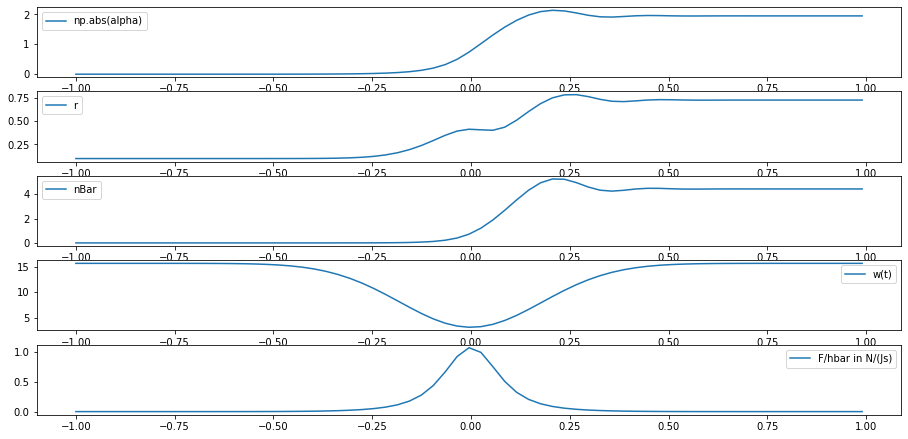

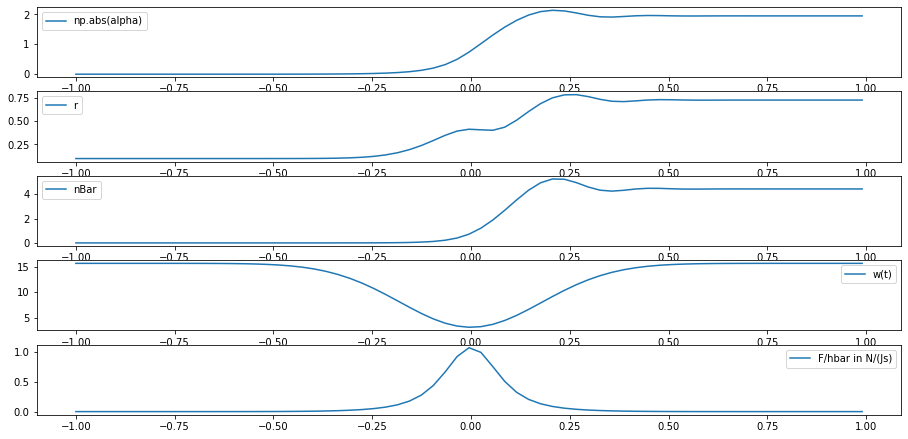

0

In [23]:
# compare both routines
plotResults(timesQQ, resultQQ, argsQQ, calculate_nT = False, nSkipp = 3, showProgress = False)
plotResults(timesQQ, resultsC, argsQQ, calculate_nT = False, nSkipp = 3, showProgress = False)

In [14]:
# t1 = time.time()
# pos = -1
# psi1 = resultQQ.states[pos]
# psi2 = resultsC.states[pos]

# plot_wigner_fock_distribution(psi1)
# plt.show()
# plot_wigner_fock_distribution(psi2)
# plt.show()
# print("processing time:", round(100*(time.time()-t1))/100, "s")

## check how many time steps are needed

In [7]:
# consider only one quench
argsC = {'n': n,
         'w0': w0,
         'dw1': -0.8*w0,
         'dt1': 0.18,
         'dw2': 0,
         'dt2': 0.18,
         'delay': 2*T+1.8098867063776491,
         'f0': 100/(9)}

In [8]:
t1 = time.time()
opt = Options()
opt.rhs_reuse = True

stepsList = np.linspace(5, 100, 20) # steps per mu s
resList = []

for n_steps in stepsList:
    timesQ = np.linspace(-1, 1, int(2*n_steps + 1))
    t2 = time.time()
    resultQ = eval_H_QQ(fock_dm(n), timesQ, argsC, options = opt)
#     resultQ = mesolve(H, fock_dm(n), timesQ, args=argsQ)
    alpha, xi, nBar, nT = getParams(resultQ.states[-1], calculate_nT = False)
    t22 = time.time() - t2
    resList.append([alpha, xi, nBar, t22])

print("processing time:", round(100*(time.time()-t1))/100, "s")

processing time: 30.14 s


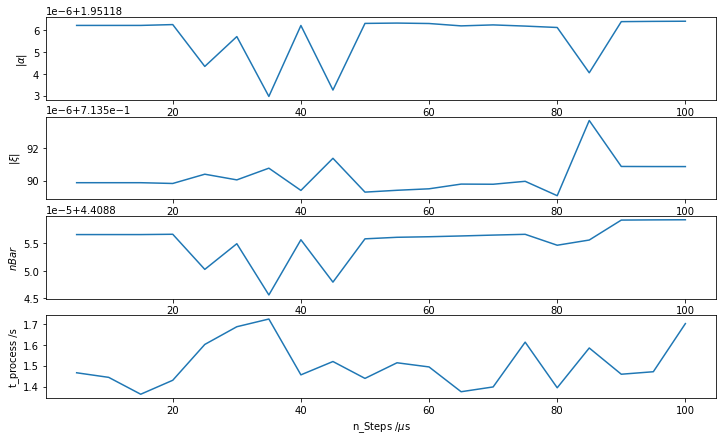

In [9]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
fig.set_size_inches(12, 7, forward=True)
ax1.plot(stepsList, [np.abs(a[0]) for a in resList])
ax1.set_ylabel(r'$|\alpha|$')
ax2.plot(stepsList, [np.abs(a[1]) for a in resList])
ax2.set_ylabel(r'$|\xi|$')
ax3.plot(stepsList, [a[2] for a in resList])
ax3.set_ylabel(r'$nBar$')
ax4.plot(stepsList, [a[3] for a in resList])
ax4.set_ylabel(r't_process /s')
ax4.set_xlabel(r'n_Steps /$\mu$s')
plt.show()

Variation of the final state for different dense lists of times given to the time evolution calculator.<br/>
Since the differences in the states are very small (check the axis scale!), the times list has no (or very little) effect on the numerical accuracy

In [10]:
t1 = time.time()
stepsList = np.linspace(50, 1000, 20) # steps per mu s
resList = []
opt = Options()
opt.rhs_reuse = True

timesQ = np.linspace(-1, 1, 101)
for n_steps in stepsList:
    opt.nsteps = n_steps
    t2 = time.time()
    resultQ = eval_H_QQ(fock_dm(n), timesQ, argsC, options = opt)
#     resultQ = mesolve(H, fock_dm(n), timesQ, args=argsQ, options=opt)
    alpha, xi, nBar, nT = getParams(resultQ.states[-1], calculate_nT = False)
    t22 = time.time() - t2
    resList.append([alpha, xi, nBar, t22])
    print("n_steps:", n_steps, "processing time:", round(100*t22)/100, "s")

print("processing time:", round(100*(time.time()-t1))/100, "s")

n_steps: 50.0 processing time: 1.57 s
n_steps: 100.0 processing time: 1.57 s
n_steps: 150.0 processing time: 1.58 s
n_steps: 200.0 processing time: 1.54 s
n_steps: 250.0 processing time: 1.46 s
n_steps: 300.0 processing time: 1.44 s
n_steps: 350.0 processing time: 1.49 s
n_steps: 400.0 processing time: 1.51 s
n_steps: 450.0 processing time: 1.45 s
n_steps: 500.0 processing time: 1.44 s
n_steps: 550.0 processing time: 1.44 s
n_steps: 600.0 processing time: 1.45 s
n_steps: 650.0 processing time: 1.54 s
n_steps: 700.0 processing time: 1.67 s
n_steps: 750.0 processing time: 1.46 s
n_steps: 800.0 processing time: 1.43 s
n_steps: 850.0 processing time: 1.45 s
n_steps: 900.0 processing time: 1.51 s
n_steps: 950.0 processing time: 1.49 s
n_steps: 1000.0 processing time: 1.59 s
processing time: 30.08 s


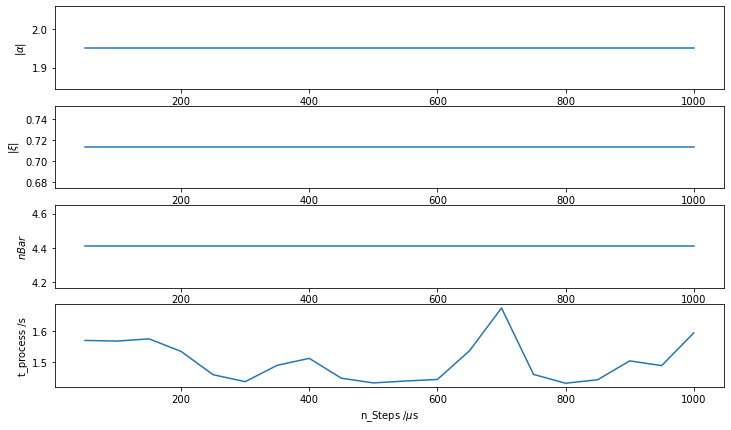

In [11]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
fig.set_size_inches(12, 7, forward=True)
ax1.plot(stepsList, [np.abs(a[0]) for a in resList])
ax1.set_ylabel(r'$|\alpha|$')
ax2.plot(stepsList, [np.abs(a[1]) for a in resList])
ax2.set_ylabel(r'$|\xi|$')
ax3.plot(stepsList, [a[2] for a in resList])
ax3.set_ylabel(r'$nBar$')
ax4.plot(stepsList, [a[3] for a in resList])
ax4.set_ylabel(r't_process /s')
ax4.set_xlabel(r'n_Steps /$\mu$s')
plt.show()

Variation of the final state for different dense lists of times given to the time evolution calculator.<br/>
Since the differences in the states are very small (check the axis scale!), the times list has no (or very little) effect on the numerical accuracy

# run the time evolution for one set of parameters above

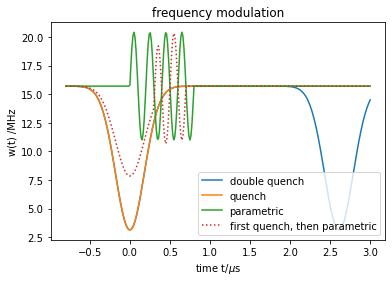

In [3]:
# plot different frequency modulations, to check that they are what I want them to be
tlist = np.linspace(-0.8,3,300)

wQuench2 = wQQ(tlist, argsQQ)
wQuench = wQP(tlist, argsQ)
wParam = wQP(tlist, argsP)
wBoth = wQP(tlist, argsQP)

plt.plot(tlist, wQuench2, label="double quench")
plt.plot(tlist, wQuench, label="quench")
plt.plot(tlist, wParam, label="parametric")
plt.plot(tlist, wBoth,":", label="first quench, then parametric")
plt.legend()
plt.title("frequency modulation")
plt.xlabel(r'time t/$\mu$s')
plt.ylabel(r'w(t) /MHz')
plt.show()

In [4]:
opt = Options()
opt.rhs_reuse = True

t1 = time.time()
resultQQ = eval_H_QQ(psi0, timesQQ, argsQQ)
resultQ = eval_H_QP(psi0, timesQ, argsQ)
resultP = eval_H_QP(psi0, timesP, argsP, options=opt)
resultQP = eval_H_QP(psi0, timesQP, argsQP, options=opt)
resultNix = eval_H_QP(psi0, timesNix, argsNix, options=opt)

print("processing time:", round(100*(time.time()-t1))/100, "s")

processing time: 43.05 s


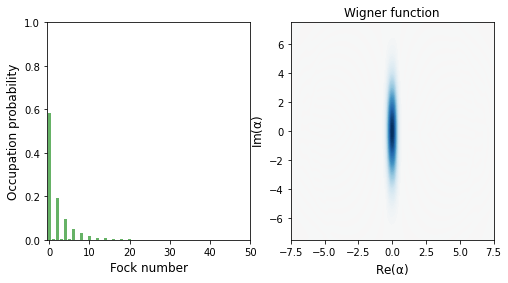

processing time: 4.73 s


In [10]:
t1 = time.time()
result = resultP
psi = result.states[-1]

plot_wigner_fock_distribution(psi)
plt.show()
print("processing time:", round(100*(time.time()-t1))/100, "s")

|alpha|= (-1.8163794055518328e-08+2.114788563150538e-08j) , xi = (1.1348466254838834+0.05232220532976938j) , nBar = 1.9507304801633996 , nT = 0.02084935431732604
xi = 1.1360521451688421 exp(i x 0.04607246297283881 )


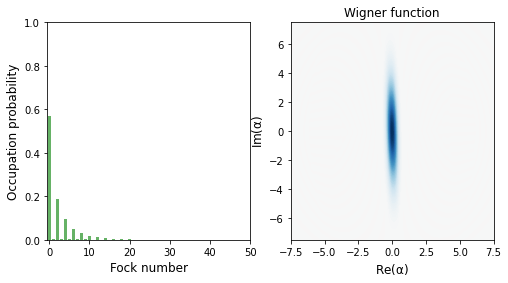

In [12]:
order_SD = False
alpha, xi, nBar, nT = getParams(psi, order_SD = order_SD)
print('|alpha|=', alpha, ', xi =', xi, ', nBar =', nBar, ', nT =', nT)
print('xi =', np.abs(xi), 'exp(i x', np.angle(xi), ')')

# depending on order_SD, the parameters are calculated for S*D or D*S
if order_SD:
    psi1 = squeeze(n, xi)*displace(n, alpha)*thermal_dm(n, nT)*displace(n, alpha).dag()*squeeze(n, xi).dag()
else:
    psi1 = displace(n, alpha)*squeeze(n, xi)*thermal_dm(n, nT)*squeeze(n, xi).dag()*displace(n, alpha).dag()
    
# plot the wiegner function, should be similar (lokking the same) as above
plot_wigner_fock_distribution(psi1)
plt.show()

Comparison between the original state (above) and the retrieved one (here).<br/>
This checks if the retrieved (above) state is close to the original one (two above), if the angle of the squeezing has wrong sign, you have to calculate nT (which takes by far the most time in the calculation of getParams). Setting order_SD true or false changes the order of the acting of squeezing and displacement.<br/>
In the next plot the time evolutin of various parameters is shown

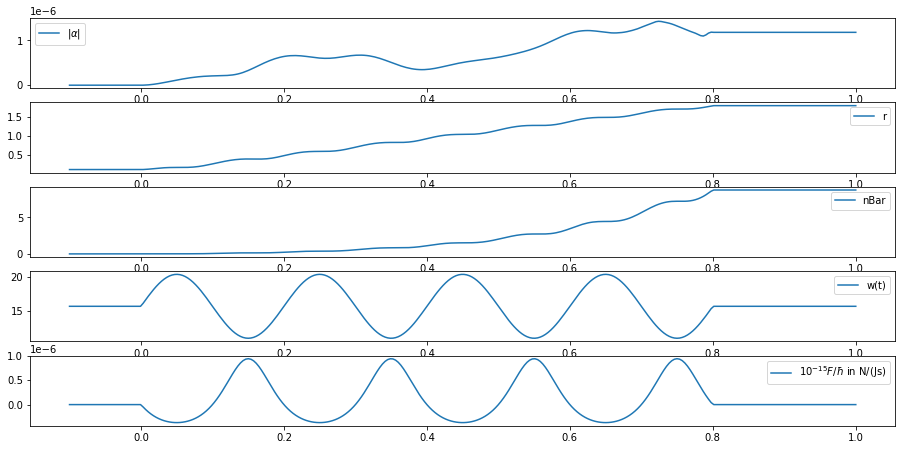

0

In [5]:
plotResults(timesP, resultP, argsP, calculate_nT = False, nSkipp = 1, showProgress = False)

## Reproduction of figure 3 in Lit early universe

In [95]:
timesP = np.linspace(-0.1,50, 1000)
w0p = 2*np.pi*2.8
T = 1/2.8
psi0p = fock_dm(n)
argsP = {'n': n,
         'omega': wQP,
         'w0': w0p,
         'dwQ': 0,
         'dtQ': 0.18,
         'dwP': 2*np.pi * 0.008,
         'dtP': 224 * 2*np.pi/(2*w0p),
         'delay': 0,
         'f0': 0.002/(9)}

In [96]:
# opt = Options()

t1 = time.time()
paramsList = []

n_steps = 15
for i in range(n_steps):
    if i % 2 == 0:
        argsP['dtP'] = 2*2**(i/2) * 2*np.pi/(2*w0p)
    else:
        argsP['dtP'] = 3*2**((i-1)/2) * 2*np.pi/(2*w0p)
        
    timesP = np.linspace(-0.1, argsP['dtP'] + 2*T, 300)
    
    # do the time evolution
    res = eval_H_QP(psi0p, timesP, argsP, options=opt)
    opt.rhs_reuse = True # speed things up after first time evolution
    opt.nsteps = 5000
    
    # get parameters
    alpha, xi, nBar, nT = getParams(res.states[-1], calculate_nT = False)
    paramsList.append([argsP['dtP'] * 2*w0p/(2*np.pi), np.abs(alpha), np.abs(xi), nBar])
#     print(argsP['dtP'] / (2*np.pi/(2*w0p)))
    
    print('\r', "Progress:", round(100*(i)/n_steps), "%", end = '')
    
print('\r', "processing time:", round(100*(time.time()-t1))/100, "s")

 processing time: 399.36 s


squeezing parameter r: 1.0053415090483295 and corresponding mean fock number <n>: 1.400578464655208


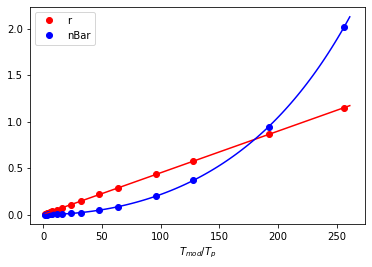

In [102]:
xlist = [a[0] for a in paramsList]
rlist = [a[2] for a in paramsList]
nlist = [a[3] for a in paramsList]
xFkt = np.linspace(xlist[0], xlist[-1]+5, 100)

def fitFktLin(x, a, b):
    return(a*x + b)

params_r, params_r_err = optimize.curve_fit(fitFktLin, xlist, rlist, p0 = [1, 0]) # do the fit for r

rPaper = fitFktLin(224, params_r[0], params_r[1])
print("squeezing parameter r:", rPaper,"and corresponding mean fock number <n>:", np.sinh(rPaper)**2)

plt.plot(xlist, rlist, 'ro', label=r'r')
plt.plot(xlist, nlist, 'bo', label=r'nBar')
plt.plot(xFkt, [fitFktLin(i, params_r[0], params_r[1]) for i in xFkt], 'r-')
plt.plot(xFkt, [np.sinh(fitFktLin(i, params_r[0], params_r[1]))**2 for i in xFkt], 'b-')
plt.xlabel(r'$T_{mod} / T_p$')
plt.legend()
plt.show()

Squeezing parameter and mean photon number $\bar{n}$ as a function of the modulation time.<br/>
This is a simulation of the experiment shown in Figure 3 in "Lit early universe", with a linear fit for the squeezing parameter $r$. The phonon number between (line) the simulation steps (dots) was calculated using $<n> = \sinh(r)^2$. In comparison to the paper, the simulation for $T_{mod} = 224 T_p$ (final point in the paper) lower squeezing by about 15% (simulation: $r = 1.005$ vs paper: $r = 1.16(5)$), and therefore a lower mean phonon number.

# check how $\alpha$ and $\xi$ depend on the pulse shape of a gaussian quench

## Reproduction of figure 3 in Lit early universe

In [35]:
n = 50 # numerical accuracy
psi0 = thermal_dm(n, 0.01)
w0 = 2*np.pi * 2.5 # in MHz
T = 1/2.5

timesQ = np.linspace(-1, 1, 200)
# argsQ = {'n': n,
#        'omega': wQP,
#        'omegaDt': wQPdot,
#        'omegaArgs': [w0, -0.8*w0, 0.18, 0, 0, 0],
#        'f0': 100/(9*10**-15)}
argsQ = {'n': n,
         'w0': w0,
         'dwQ': -0.8*w0,
         'dtQ': 0.18,
         'dwP': 0,
         'dtP': 0,
         'delay': 0,
         'f0': 100/(9)}

In [31]:
# choose different pulse lengths and see what impact that has on alpha and xi
t1 = time.time()

opt = Options()
opt.rhs_reuse = False

dts = np.linspace(0.04, 0.4, 19, endpoint = False) # from 0.1T to 3T
dts = np.append(dts, np.linspace(0.4, 1.6, 13))
xis = []
alphas = []
for dt in dts:
#     argsQ['omegaArgs'][2] = dt
    argsQ['dtQ'] = dt
#     result = mesolve(H, psi0, timesQ, args=argsQ)
    result = eval_H_QP(psi0, timesQ, argsQ, options=opt)
    alpha, xi,_,_ = getParams(result.states[-1], calculate_nT = False)
    
    xis.append(np.abs(xi))
    alphas.append(np.abs(alpha))
    opt.rhs_reuse = True
    print('\r', "Progress:", round(100*(dt-dts[0])/(dts[-1]-dts[0])), "%", end = '')

argsQ['dtQ'] = 0.18    
print('\r', "processing time:", round(100*(time.time()-t1))/100, "s")

 processing time: 45.68 s


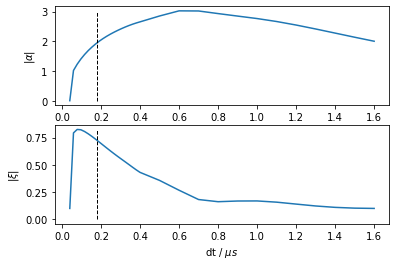

In [32]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(dts, alphas)
ax1.plot([0.18, 0.18], [0., max(alphas)], 'k--', linewidth=1)
ax1.set_ylabel(r'$|\alpha|$')
ax2.plot(dts, xis)
ax2.plot([0.18, 0.18], [0., max(xis)], 'k--', linewidth=1)
ax2.set_ylabel(r'$|\xi|$')
ax2.set_xlabel(r'dt / $\mu s$')
plt.show()

coherent displacement and squeezing depending on the pulse duration <br/>
For a gaussian pulse with minimum $\Delta \omega = -0.8 \omega_0$ and pulse durations $dt$ between $0.1 T$ and $2.2 T$ (with $T = 2 \pi/\omega_0$), the coherent displacement $|\alpha |$ and the squeezing $|\xi |$ are calculated. $|\alpha |$ rises monoton and $|\xi |$ has a maximum at very short pulse durations and decreases monotonly for higher $dt$. This shows that a single gaussian pulse is not sufficent to create a squeezed state without coherent displacement. <br/>
The dashed line indicates the pulse length of the pulses taken for further calculations (especially in the investigation of the double pulse sequence)

In [38]:
# check how alpha and xi (both r and t) depend on the pulse strength

t1 = time.time()

opt = Options()
opt.rhs_reuse = False

dws = np.linspace(0, 0.8, 17)
xiRs = []
xiTs = []
alphas2 = []
alphasT2 = []
for dw in dws:
#     argsQ['omegaArgs'][1] = -dw*w0
    argsQ['dwQ'] = -dw*w0
#     result = mesolve(H, psi0, timesQ, args=argsQ)
    result = eval_H_QP(psi0, timesQ, argsQ, options=opt)
    alpha, xi,_,_ = getParams(result.states[-1], calculate_nT = False)
    
    xiRs.append(np.abs(xi))
    if np.angle(xi)<0:
        xiTs.append(np.angle(xi) + 2*np.pi)
    else:
        xiTs.append(np.angle(xi))
    
    alphas2.append(np.abs(alpha))
    if np.angle(alpha)<0:
        alphasT2.append(np.angle(alpha) + 2*np.pi)
    else:
        alphasT2.append(np.angle(alpha))
        
    opt.rhs_reuse = True
    print('\r', "Progress:", round(100*(dw-dws[0])/(dws[-1]-dws[0])), "%", end = '')
    
argsQ['dwQ'] = -0.8*w0
print('\r', "processing time:", round(100*(time.time()-t1))/100, "s")

 processing time: 29.62 s


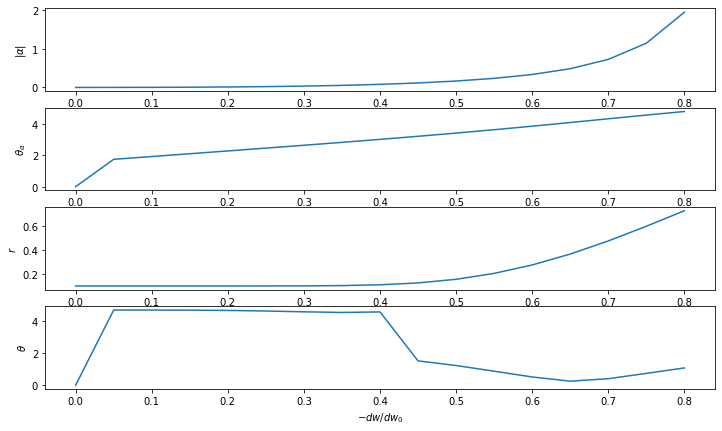

In [39]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
fig.set_size_inches(12, 7, forward=True)
ax1.plot(dws, alphas2)
ax1.set_ylabel(r'$|\alpha|$')

ax2.plot(dws, alphasT2)
ax2.set_ylabel(r'$\theta_\alpha$')

ax3.plot(dws, xiRs)
ax3.set_ylabel(r'$r$')

ax4.plot(dws, xiTs)
ax4.set_ylabel(r'$\theta$')
ax4.set_xlabel(r'$- dw / dw_0$')
plt.show()

dependence of $\alpha$ and $\xi = r e^\theta$ on the pulse strength $\Delta$w

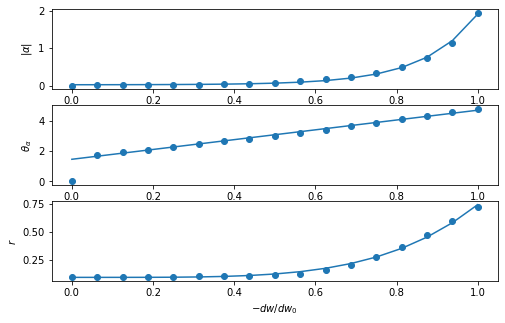

params for alpha: [1.00398441e-03 7.54397528e+00 1.96151880e-02] Errors: [5.05609275e-08 5.18454587e-02 9.83173144e-05]
params for alpha_T: [3.23949299 1.46292252] Errors: [0.00255979 0.00093492]
params for xiR: [0.65237181 4.43040854 0.09222313] Errors: [1.33492772e-04 2.79816687e-02 2.25094343e-05]


In [40]:
# fit a quadratic polynom on the minimum to get a more exact position
def fitFktPol(x, a, b, c):
    return(a*(x**b) + c)

def fitFktExp(x, a, b, c):
    return(a*np.exp(b*x) + c)

def fitFktLin(x, a, b):
    return(a*x+b)

xFit = dws/0.8
paramsA, paramsA_err = optimize.curve_fit(fitFktExp, xFit, alphas2, p0 = [1, 1, 0]) # do the fit for alpha
paramsAT, paramsAT_err = optimize.curve_fit(fitFktLin, xFit[1:], alphasT2[1:], p0 = [0, 0]) # do the fit for alpha, angle in C
paramsX, paramsX_err = optimize.curve_fit(fitFktPol, xFit, xiRs, p0 = [1, 1, 0]) # do the fit for xi

fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_size_inches(8, 5, forward=True)

ax1.scatter(xFit, alphas2)
ax1.plot(xFit, fitFktExp(xFit, paramsA[0], paramsA[1], paramsA[2]))
ax1.set_ylabel(r'$|\alpha|$')

ax2.scatter(xFit, alphasT2)
ax2.plot(xFit, fitFktLin(xFit, paramsAT[0], paramsAT[1]))
ax2.set_ylabel(r'$\theta_\alpha$')

ax3.scatter(xFit, xiRs)
ax3.plot(xFit, fitFktPol(xFit, paramsX[0], paramsX[1], paramsX[2]))
ax3.set_ylabel(r'$r$')
ax3.set_xlabel(r'$- dw / dw_0$')
plt.show()

print("params for alpha:", paramsA, "Errors:", np.diagonal(paramsA_err))
print("params for alpha_T:", paramsAT, "Errors:", np.diagonal(paramsAT_err))
print("params for xiR:", paramsX, "Errors:", np.diagonal(paramsX_err))

Fit of a polynomial or exponential function on the developement of dw <br/>
One finds that for the coherent displacement $\alpha$, an exponential fit of the form $\alpha(dw) = a \cdot exp(b \cdot dw) + c$ gives the best results. For the squeezing parameter $r$ a polynomial Fit of the form $r(dw) = a \cdot (dw)^b + c$ gives the best result.

# Spin-Phonon-Coupling

## set Parameters and compare simulation with theory

In [71]:
# setting parameters for this section
n = 20
n_LD = 0.1
w0 = 2*np.pi*2.5
Omega = 2*np.pi*3.7

# psiPS_P = fock_dm(n, 7) # single fock state
psiPS_P = 0.5*(fock_dm(n, 1)+fock_dm(n, 4)) # superposition of fock states
# psiPS_P = coherent_dm(n, 1+1j) # coherent state

psiPS = tensor(fock_dm(2, 0), psiPS_P)

# wz = 1775*2*pi

argsPS = {
    'n': n,
    'n_LD': n_LD,
    'w0': w0,
    'wz': w0,
    'Omega': 2*np.pi*3.7
}

pg = tensor(Qobj([[1,0],[0,0]]), qeye(n)) # projector on the ground state

In [4]:
# do the time evolution

opt = Options()
# opt.rhs_reuse = True

t1 = time.time()
times = np.linspace(0, 10, 1001)
res = eval_H_spin_phonon_coupling(psiPS, times, argsPS, options=opt, expect=pg, n_LD_small = False)
# plot_wigner_fock_distribution(psiPS)
print(round(time.time()-t1), "s")

22 s


L2 distance between expectation and time evolution: 0.08025627957442756


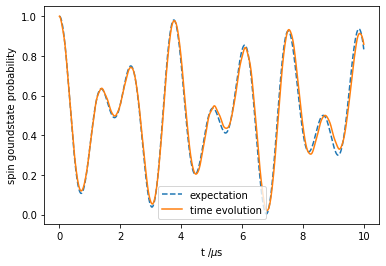

In [5]:
# get the diagonal elements (= (|n><psi|)^2) of the density matrix
list_Pn = np.abs(np.diag(psiPS_P.full()))

# get the expected ground state probability
probs = 0.5
for i in range(n):
    probs += 0.5*list_Pn[i]*np.cos(RabiTPSR(Omega, n_LD, i, -1)*times)

diff = np.sqrt(np.sum(np.abs(res.expect[0]-probs)**2))/(times[-1] - times[0])
print("L2 distance between expectation and time evolution:", diff)    

# plot the expected ground state probability
plt.plot(times, probs, "--", label="expectation")

# plot the calculated (via the time evolution of the spin phonon Hamiltonian) ground state probability
plt.plot(times, res.expect[0], label="time evolution")
plt.xlabel(r't /$\mu$s')
plt.ylabel(r'spin goundstate probability')
plt.legend()
plt.show()

Occupation probability of the spin ground state (initial in the spin excited state), expected and calculated via the spin phonon coupling Hamiltonian.<br/>
The ground state occupation was calcuated first doing the time evolution of the spin phonon coupling Hamiltonian, second using the analytical formula (95) from LBM+03. For similar results, the Lamb Dicke parameter needs to be small and the motional frequency $w_z$ must be the same as the spin frequency $w_0$.

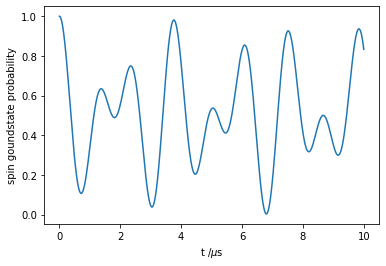

In [6]:
# get the diagonal elements (= (|n><psi|)^2) of the density matrix
list_Pn = np.abs(np.diag(psiPS_P.full()))

probs = 0.5
for i in range(n):
    probs += 0.5*list_Pn[i]*np.cos(RabiTPSR(Omega, n_LD, i, -1)*times)

# probs = 0.5*(1+0.5*np.cos(RabiTPSR(Omega, n_LD, 1, 2)*times) + 0.5*np.cos(RabiTPSR(Omega, n_LD, 4, 5)*times)) # superposition of fock states, by hand
plt.plot(times, probs)
plt.xlabel(r't /$\mu$s')
plt.ylabel(r'spin goundstate probability')
plt.show()

Expected ground state occupation.<br/>
Ground state occupation calculated with formula (95) of LBM+03 with the values from above (simulated ground state occupation). For results similar to the simulation, the Lamb Dicke parameter needs to be small and the motional frequency $w_z$ must be the same as the spin frequency $w_0$.

## check how large the regime of small Lamb Dick parameter is
uses the results from the previous section

In [34]:
listLD = np.linspace(0, 0.3, 13)
diffList_exp = []
diffList_LD = []

t1 = time.time()
for n_LD in listLD:
    # update the lamb dicke parameter
    argsPS['n_LD'] = n_LD
    
    # do the time evolution
    res1 = eval_H_spin_phonon_coupling(psiPS, times, argsPS, expect=pg)
    res2 = eval_H_spin_phonon_coupling(psiPS, times, argsPS, expect=pg, n_LD_small = True)

    # get the expected ground state probability
    probs = 0.5
    for i in range(n):
        probs += 0.5*list_Pn[i]*np.cos(RabiTPSR(Omega, n_LD, i, -1)*times)
    
    # calculate the L2 difference between the expected result and the time evolution
    diffList_exp.append(np.sqrt(np.sum(np.abs(res1.expect[0]-probs)**2))/(times[-1] - times[0]))
    diffList_LD.append(np.sqrt(np.sum(np.abs(res1.expect[0]-res2.expect[0])**2))/(times[-1] - times[0]))
    
    print('\r', "Progress:", round(100*(n_LD)/listLD[-1]), "%", end = '')

print('\r', "processing time:", round(100*(time.time()-t1))/100, "s")

 processing time: 287.47 s


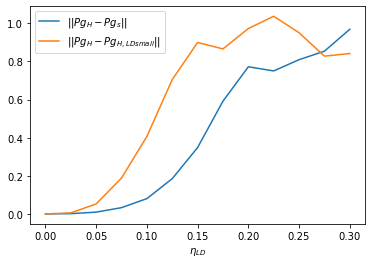

In [37]:
plt.plot(listLD, diffList_exp, label=r'$||Pg_H - Pg_s||$')
plt.plot(listLD, diffList_LD, label=r'$||Pg_H - Pg_{H, LD small}||$')
plt.legend()
plt.xlabel(r'$\eta_{LD}$')
plt.show()

For different Lamb Dicke Parameters $\eta_{LD}$, the L2 distance of the time evolution of the spin ground state population calculated with the spin phonon coupling hamiltonian to:<br/>
1. the expected spin ground state population (which assumes small $\eta_{LD}$)
2. the spin ground state population calculated with an approximation of the spin phonon coupling hamiltonian for small $\eta_{LD}$

are calculated. In the first case, both results are quite close to each other for approximately $\eta_{LD} \in \left[ 0, 0.1\right]$, in the second case for $\eta_{LD} \in \left[ 0, 0.05\right]$.

16


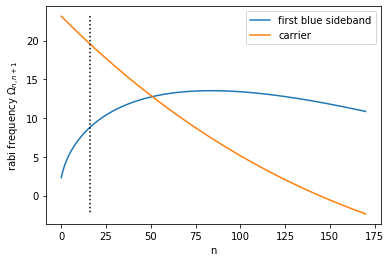

In [72]:
# Omega = 5*Omega

# fock states, for which the Rabi rate is calculated
nList = np.arange(171)

# calculation of the rabi rate for the carrier (2) and the first blue sideband (1)
rList1 = []
rList2 = []
[rList1.append(RabiTPSR(Omega, 0.1, n1, -1)) for n1 in nList]
[rList2.append(RabiTPSR(Omega, 0.1, n1, n1)) for n1 in nList]



# check at which point the difference of rabi rates between next neighbours from the carrier gets larger than the blue sideband
n_same = 0
while rList1[n_same+1] - rList1[n_same] > -rList2[n_same+1] + rList2[n_same]:
    n_same += 1
print(n_same)

# plot results
plt.plot(nList, rList1, label="first blue sideband")
plt.plot(nList, rList2, label="carrier")
plt.plot([n_same, n_same],[max(rList2), min(rList2)], 'k:')
plt.legend()
plt.xlabel(r'n')
plt.ylabel(r'rabi frequency $\Omega_{n, n+1}$')
plt.show()

Rabi rates dependant on n for the carrier and the first blue sideband. The larger the derivative, the easier is it to differentiate between different fock states from the time evolution of the state under the spin phonon coupling. The black dotted line indicates where both derivatives are the same.

## simulate an experiment using QPN

processing time: 0.01 s


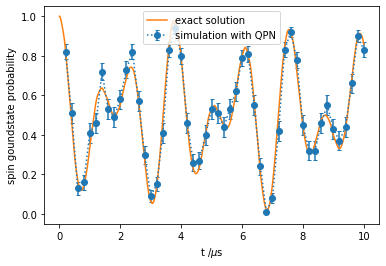

In [66]:
np.random.seed(4200)
t1 = time.time()
n_points = 50
n_samples = 100
probs = res.expect[0]
t_max = times[-1]
n_t = len(times)

idVals = []
[idVals.append(int((i+1)*1000/n_points)) for i in range(n_points)]

# rss = np.random.rand(n_samples*n_points)

tVals = []
yVals = []
yErrs = []
# j = 0
for i in idVals:
    tVals.append(i/(n_t-1)*t_max)
    
    Pys = np.full(n_samples, probs[i])
    rs = np.random.rand(n_samples)
    ys = rs < Pys # check which random numbers are lower than Py (keep in mind: True = 1, False = 0)
    yVals.append(np.mean(ys))
    yErrs.append(np.sqrt(np.var(ys)/n_samples))
#     j += 1

print("processing time:", round(1000*(time.time()-t1))/1000, "s")

plt.errorbar(tVals, yVals, yerr=yErrs, fmt = 'o:', capsize = 2, label="simulation with QPN")
plt.plot(times, probs, label="exact solution")
plt.legend()
plt.xlabel(r't /$\mu$s')
plt.ylabel(r'spin goundstate probability')
plt.show()


Simulation of experimental data for the ground state occupation.<br/>
From the groundstate occupation probability calculated above, experimental data is generated by randomly projecting the state into its spin ground or excited state (a random number is generated, which, comparing it to the calculated probability, determines the systems state). For each point, several experiments are simulated, the mean and its standard derivation are depicted here.

In [8]:
from PyModules import test_rt
test_rt.test_PyMod(0.5)

yay, funktioniert


42.5

In [18]:
from PyModules.epos import EPOS
x = EPOS()
# ddd.single_fit_carrier_data()

socket connecting to /tmp/socket-eios-cmd


Exception: Socket /tmp/socket-eios-cmd could not be found! Check EIOS!

In [11]:
if False:
    print(1)
elif True:
    print(2)    

2
